In [23]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [25]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp

import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
from scipy import optimize
import arrow
import gsw
import pandas as pd
%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Use Tetjana's isopycnal vs ventilation age



    1) plot age of water as fxn of isopycnal - use scipy-optimize...
    2) plot intrusion of pco2 as fxn of age...what is the 'correct' reference here?
    
problem - the age of water as a function of isopycnal gets very exponential very quickly- an isopycnal of 25.7 has an age of ~320 years. 


### atmospheric CO2 - used co2levels.org data sources, 
### smoothed yearly product (ice core 1832-1959, maunaloa 1959-pres)

1832- 1958: https://cdiac.ess-dive.lbl.gov/ftp/trends/co2/lawdome.combined.dat
1959 - pres: https://www.co2levels.org/#sources
### 

### PPM CO2 from 1832-2018, using above sources, and code to look up atmco2 for a given year from 1832-2018

In [26]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 


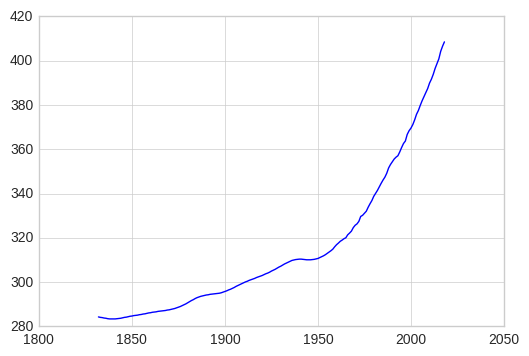

In [27]:
plt.plot(co2_rec['YEAR'],co2_rec['PPMCO2'])

In [28]:
def co2_from_year(year):
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #print('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #print('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2

In [29]:
ty = 1000
tco2 = co2_from_year(ty)
print(tco2)

284.3


## from Tetjana's plot, define pycnals and ventilation age, use scipy curve_fit to make a fxn of ventilation time/year last at surface vs pycnal, use above code to find atm co2 when pycnal was last at surface

In [30]:

pycnal = np.array([24.4, 25.15, 25.4, 25.6])
pycnal_age = np.array([0,1,10,100])

def test_func(x, a, b, c):
    return a * np.exp(-b * (25.15-x)) + c

params, params_covariance = optimize.curve_fit(test_func, pycnal, pycnal_age,
                                               p0=[1, -0.05, -25.15])
params0 = params[0]
params1 = params[1]
params2 = params[2]


pycnal_forfunc =np.arange(24.4,27,0.05)
pycnal_age_fromfunc = params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2
pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)

for i in range(0,len(pycnal_original_co2)):
    ty = pycnal_last_at_surface[i]
    tco2 = co2_from_year(ty)
    pycnal_original_co2[i] = tco2
    
    
pycnal_intrusion = 409 - pycnal_original_co2


## ventilation age as a fxn of isopycnal, station P04, km 220

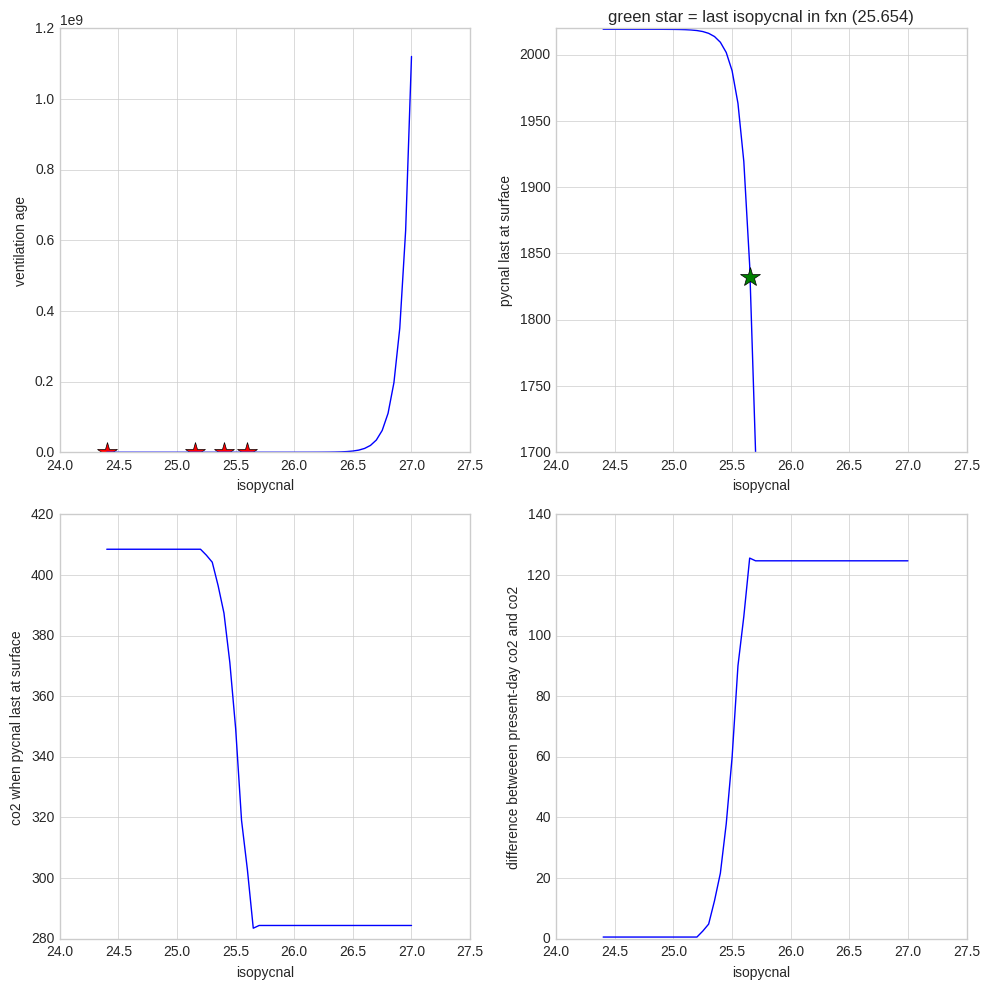

In [31]:
fig = plt.figure(figsize=(10,10))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,2,i)
        ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_age_fromfunc)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('ventilation age')
        

    if i == 2:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_last_at_surface)
        ax.plot(25.654,1832.1497986658724,'g*', markersize = 15)
        ax.set_ylim([1700,2020])
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('pycnal last at surface')
        ax.set_title('green star = last isopycnal in fxn (25.654)')

    if i == 3:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_original_co2)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('co2 when pycnal last at surface')


    if i == 4:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_intrusion)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('difference betweeen present-day co2 and co2')

   
        
plt.tight_layout()

In [32]:
pycnal_forfunc2 = 25.654
pycnal_age_fromfunc = params[0] *np.exp(-params[1]*(25.15-pycnal_forfunc2))+params[2]

pycnal_last_at_surface = 2019 - pycnal_age_fromfunc
print('Max pycnal for function: ', pycnal_forfunc2)
print('last at surface:', pycnal_last_at_surface)

Max pycnal for function:  25.654
last at surface: 1832.1497986658724


In [33]:
# test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
# zlevels = (test_LO['deptht'][:])
# sal = test_LO['vosaline'][0,:,0,:]
# temp = test_LO['votemper'][0,:,0,:]
# potdens = gsw.sigma0(sal,temp)
# print('max pot dens:', np.max(potdens))
# print('min pot dens:', np.min(potdens))
# potdens_mask = np.copy(potdens)
# potdens_mask[potdens>24.4] = 1
# potdens_mask[potdens<=24.4] = -1
# potdens_age = np.copy(potdens)

# for i in range(0,40):
#     for j in range(0,950):
#         potdens_age[i,j] = params[0] *np.exp(-params[1]*(25.15-potdens[i,j]))+params[2] 
# potdens_age[potdens<=24.4] = 0
# potdens_age[potdens_age>129] = 129


# w = np.where( potdens > 25.7 )

# #print('size of BC array:' np.size(potdens))
# print('Proportion of BC array > 25.7:', np.size(w)/np.size(potdens))


In [34]:
# fig = plt.figure(figsize=(11,3.5))
# nop = 4
# for i in range(1,nop+1):

#     if i == 1:
#         ax = fig.add_subplot(1,4,i)
#         section_slice = np.arange(0, 95)
#         sd = (potdens)
#         tplt = np.ma.masked_values(sd,0)
#         tcmap = cm.cm.deep
#         cmap = tcmap
#         mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=20, vmax=30)
#         cbar = fig.colorbar(mesh, ax=ax)
#         ax.invert_yaxis()
#         land_colour = 'slategrey'
#         cmap.set_bad(land_colour)
#         plt.title('potential density of BC') 
#         ax.set_ylabel('depth')
#         ax.set_xticklabels([])
        
#     if i == 2:
#         ax = fig.add_subplot(1,4,i)
#         section_slice = np.arange(0, 95)
#         sd = (potdens_mask)
#         tplt = np.ma.masked_values(sd,0)
#         tcmap = cm.cm.balance
#         cmap = tcmap
#         mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-1, vmax=1)
#         cbar = fig.colorbar(mesh, ax=ax)
#         ax.invert_yaxis()
#         land_colour = 'slategrey'
#         cmap.set_bad(land_colour)
#         plt.title('potential density of BC (1 means >24.4)') 
#         ax.set_ylabel('depth')
#         ax.set_xticklabels([])

      
# plt.suptitle('y2018m01d01', fontsize = 15)
# plt.tight_layout()

## Visualize potential density of incoming BC waters - see where it is >24.4

#### June 1, 2018 - more 'exciting' - deeper waters coming up

In [35]:
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc')
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
potdens = gsw.sigma0(sal,temp)
potdens_mask = np.copy(potdens)
potdens_mask[potdens>24.4] = 1
potdens_mask[potdens<=24.4] = -1

DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]

depth_this = np.zeros_like(TA)

for i in range(0,950):
    depth_this[:,i] = zlevels

In [36]:

pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-potdens))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)
np.shape(pycnal_original_co2)
for i in range(0,40):
    for j in range(0,950):
        ty = pycnal_last_at_surface[i,j]
        tco2 = co2_from_year(ty)
        pycnal_original_co2[i,j] = tco2


pycnal_intrusion = 409 - pycnal_original_co2

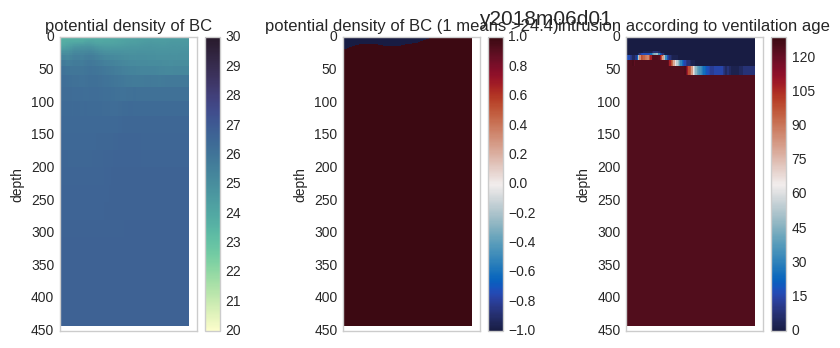

In [39]:
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (potdens)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=20, vmax=30)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (potdens_mask)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-1, vmax=1)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC (1 means >24.4)') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_intrusion)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=0, vmax=129)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('intrusion according to ventilation age') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])    

        
plt.suptitle('y2018m06d01', fontsize = 15)
plt.tight_layout()